# Initialize

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import to_categorical

import time
import keras.backend as K
from keras import Input, Model
from keras.layers import Convolution2D, LeakyReLU, BatchNormalization, Conv2D, UpSampling2D, Subtract, Concatenate, Softmax, Dropout, Activation,MaxPooling2D, Flatten, Dense, Lambda, Reshape, concatenate, ZeroPadding2D, Cropping2D
from keras.optimizers import Adam
import tensorflow as tf
from keras.models import Sequential

Using TensorFlow backend.


# Loading Data

In [ ]:
Download = True #@param {type:"boolean"}

if Download:
  !gdown "https://drive.google.com/uc?id=112_Fj220WSbFf1a1C4N6tKg5FR0wyyUa" -O "final.zip"
else:
  !cp '/content/drive/My Drive/data/final.zip' './final.zip' 

!mkdir all
!unzip  "final.zip" -d "./all"

Streaming output truncated to the last 5000 lines.
  inflating: ./all/content/D/images/035284.jpg  
  inflating: ./all/content/D/images/038810.jpg  
  inflating: ./all/content/D/images/020482.jpg  
  inflating: ./all/content/D/images/032316.jpg  
  inflating: ./all/content/D/images/038318.jpg  
  inflating: ./all/content/D/images/054403.jpg  
  inflating: ./all/content/D/images/030916.jpg  
  inflating: ./all/content/D/images/055003.jpg  
  inflating: ./all/content/D/images/034191.jpg  
  inflating: ./all/content/D/images/028667.jpg  
  inflating: ./all/content/D/images/017410.jpg  
  inflating: ./all/content/D/images/045528.jpg  
  inflating: ./all/content/D/images/024843.jpg  
  inflating: ./all/content/D/images/007648.jpg  
  inflating: ./all/content/D/images/005513.jpg  
  inflating: ./all/content/D/images/034359.jpg  
  inflating: ./all/content/D/images/023418.jpg  
  inflating: ./all/content/D/images/021802.jpg  
  inflating: ./all/content/D/images/032761.jpg  
  inflating: ./all

In [ ]:
import os

depth_filenames = os.listdir("/content/all/content/D/depth")
rgb_filenames = os.listdir("/content/all/content/D/images")

if depth_filenames == rgb_filenames:
  print("Data correct")
else:
  print("Data incorrect") 

Data correct


In [ ]:
def get_paths(file_pahts, val_size=2000):

  return pd.DataFrame({'path':file_pahts[:-val_size]}), pd.DataFrame({'path':file_pahts[-val_size:]})

img_paths_train, img_paths_val = get_paths(rgb_filenames)

In [ ]:
img_paths_train

,path
0,038124.jpg
1,029789.jpg
2,028613.jpg
3,030639.jpg
4,029199.jpg
...,...
18749,010599.jpg
18750,054446.jpg
18751,044737.jpg
18752,020501.jpg


In [ ]:
img_paths_val

,path
0,039295.jpg
1,008188.jpg
2,024109.jpg
3,016500.jpg
4,030089.jpg
...,...
1995,009935.jpg
1996,028847.jpg
1997,005981.jpg
1998,036311.jpg


In [ ]:
def rgb_to_depth(image):

    array = image.astype(np.float32)
    normalized_depth = np.dot(array[:, :, :3], [65536.0, 256.0, 1.0])
    normalized_depth /= 16777215.0  
    return normalized_depth

# Image Augmentation

In [ ]:
from skimage.util import random_noise
from PIL import Image, ImageEnhance, ImageOps
from itertools import product, permutations

def add_noise(image):
    return (random_noise(image/255)*255).astype('int')

def color_change(image):
  indices = list(permutations(range(3), 3))  
  idx = np.random.randint(0, len(indices) - 1)
  return image[..., indices[idx]]

def flip(image, depth):
                                                                     # Horizontal
  image, depth = np.flip(image, 1), np.flip(depth, 1)
  #if np.random.random() < augmentation_rate:                 # Vertical
  #  image, depth = np.flip(image, 0), np.flip(depth, 0)

  return image, depth

def eraser(input_img, p=0.3, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=True):
  
  input_img = input_img.copy()
  img_h, img_w, img_c = input_img.shape

  p1 = np.random.rand()
  if p1 > p:
      return input_img

  while True:
      s = np.random.uniform(s_l, s_h) * img_h * img_w
      r = np.random.uniform(r_1, r_2)
      w = int(np.sqrt(s / r))  
      h = int(np.sqrt(s * r))
      left = np.random.randint(0, img_w)
      top = np.random.randint(0, img_h)

      if left + w <= img_w and top + h <= img_h:
          break

  if pixel_level:
      c = np.random.uniform(v_l, v_h, (h, w, img_c))
  else:
      c = np.random.uniform(v_l, v_h)

  input_img[top:top + h, left:left + w, :] = c

  return input_img

def corrections(image):

  funcs = {
            "color": lambda img, magnitude: ImageEnhance.Color(img).enhance(1 + magnitude * random.choice([-1, 1])),
            "posterize": lambda img, magnitude: ImageOps.posterize(img, magnitude),
            "solarize": lambda img, magnitude: ImageOps.solarize(img, magnitude),
            "contrast": lambda img, magnitude: ImageEnhance.Contrast(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "sharpness": lambda img, magnitude: ImageEnhance.Sharpness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "brightness": lambda img, magnitude: ImageEnhance.Brightness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "autocontrast": lambda img, magnitude: ImageOps.autocontrast(img),
            "equalize": lambda img, magnitude: ImageOps.equalize(img),
            "invert": lambda img, magnitude: ImageOps.invert(img)
          }

def augment(image, functions=[add_noise, color_change]):

  function = np.random.choice(functions)
  aug_img = function(image)

  return aug_img.astype('int')

0 199


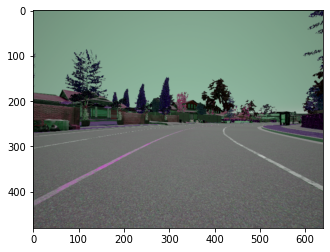

In [ ]:
test = cv2.cvtColor(cv2.imread('/content/all/content/D/images/023833.jpg'), cv2.COLOR_BGR2RGB)

x = augment(test)
print(x.min(), x.max())

plt.imshow(x)

# Setting Up Model

In [ ]:
from keras import applications
from keras.models import Model, load_model
from keras.engine.topology import Layer, InputSpec
import keras.utils.conv_utils as conv_utils

class BilinearUpSampling2D(Layer):
    def __init__(self, size=(2, 2), data_format=None, **kwargs):
        super(BilinearUpSampling2D, self).__init__(**kwargs)
        self.data_format = K.normalize_data_format(data_format)
        self.size = conv_utils.normalize_tuple(size, 2, 'size')
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            height = self.size[0] * input_shape[2] if input_shape[2] is not None else None
            width = self.size[1] * input_shape[3] if input_shape[3] is not None else None
            return (input_shape[0],
                    input_shape[1],
                    height,
                    width)
        elif self.data_format == 'channels_last':
            height = self.size[0] * input_shape[1] if input_shape[1] is not None else None
            width = self.size[1] * input_shape[2] if input_shape[2] is not None else None
            return (input_shape[0],
                    height,
                    width,
                    input_shape[3])

    def call(self, inputs):  
        input_shape = K.shape(inputs)
        if self.data_format == 'channels_first':
            height = self.size[0] * input_shape[2] if input_shape[2] is not None else None
            width = self.size[1] * input_shape[3] if input_shape[3] is not None else None
        elif self.data_format == 'channels_last':
            height = self.size[0] * input_shape[1] if input_shape[1] is not None else None
            width = self.size[1] * input_shape[2] if input_shape[2] is not None else None
        
        return tf.image.resize(inputs, [height, width], method=tf.image.ResizeMethod.BILINEAR)

    def get_config(self):
        config = {'size': self.size, 'data_format': self.data_format}
        base_config = super(BilinearUpSampling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
from keras.layers import Input, InputLayer, Conv2D, Activation, LeakyReLU, Concatenate

def create_model(existing='', is_twohundred=False, is_halffeatures=True):
        
    if len(existing) == 0:
        print('Loading base model (DenseNet)..')

        # Encoder Layers
        if is_twohundred:
            base_model = applications.DenseNet201(input_shape=(480, 640, 3), include_top=False)
        else:
            base_model = applications.DenseNet169(input_shape=(480, 640, 3), include_top=False)

        print('Base model loaded.')

        # Starting point for decoder
        base_model_output_shape = base_model.layers[-1].output.shape

        # Layer freezing?
        for layer in base_model.layers: layer.trainable = True

        # Starting number of decoder filters
        if is_halffeatures:
            decode_filters = int(int(base_model_output_shape[-1])/2)
        else:
            decode_filters = int(base_model_output_shape[-1])

        # Define upsampling layer
        def upproject(tensor, filters, name, concat_with):
            up_i = BilinearUpSampling2D((2, 2), name=name+'_upsampling2d')(tensor)
            up_i = Concatenate(name=name+'_concat')([up_i, base_model.get_layer(concat_with).output]) # Skip connection
            up_i = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', name=name+'_convA')(up_i)
            up_i = LeakyReLU(alpha=0.2)(up_i)
            up_i = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', name=name+'_convB')(up_i)
            up_i = LeakyReLU(alpha=0.2)(up_i)
            return up_i

        # Decoder Layers
        decoder = Conv2D(filters=decode_filters, kernel_size=1, padding='same', input_shape=base_model_output_shape, name='conv2')(base_model.output)

        decoder = upproject(decoder, int(decode_filters/2), 'up1', concat_with='pool3_pool')
        decoder = upproject(decoder, int(decode_filters/4), 'up2', concat_with='pool2_pool')
        decoder = upproject(decoder, int(decode_filters/8), 'up3', concat_with='pool1')
        decoder = upproject(decoder, int(decode_filters/16), 'up4', concat_with='conv1/relu')
        if False: decoder = upproject(decoder, int(decode_filters/32), 'up5', concat_with='input_1')

        # Extract depths (final layer)
        conv3 = Conv2D(filters=1, kernel_size=3, strides=1, padding='same', name='conv3')(decoder)

        model = Model(inputs=base_model.input, outputs=conv3)
    else:
        custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': depth_loss_function}
        model = load_model(existing, custom_objects=custom_objects)
        print('\nExisting model loaded.\n')

    print('Model created.')
    
    return model

In [ ]:
def get_simple_model():
    model = Sequential()
  
    model.add(Conv2D(16, (5, 5), strides=2, padding='same', input_shape=(240, 320, 3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(32, (5, 5), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(64, (3, 3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(128, (3, 3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(256, (3, 3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(256, (3, 3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(BilinearUpSampling2D((2, 2)))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(BilinearUpSampling2D((2, 2)))
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Cropping2D(cropping=((1, 0), (0, 0))))

    model.add(BilinearUpSampling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(BilinearUpSampling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(BilinearUpSampling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(BilinearUpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(16, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(1, (5, 5), activation='softmax', padding='same'))

    return model

model = get_simple_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 120, 160, 16)      1216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 120, 160, 16)      64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 120, 160, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 80, 32)        12832     
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 80, 32)        128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 60, 80, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 40, 64)       

In [ ]:
# Final Model
model = create_model()
model.summary()

Loading base model (DenseNet)..
Base model loaded.
Model created.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 640, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 486, 646, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 240, 320, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 240, 320, 64) 256         conv1/conv[0][0]                 
__________________________

In [ ]:
from keras.optimizers import Nadam, Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from time import time

#optimizer = Nadam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
optimizer = Adam(lr=0.0001)
tensorboard = TensorBoard(log_dir="./drive/My Drive/Self Driving/logs/DenseDepth2/{}".format(time()), histogram_freq=1, write_graph=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=30)

filepath = "./drive/My Drive/Self Driving/DenseDepth/" + "DenseDepth2-" + "saved-model-{epoch:03d}-{val_loss:.5f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False)
callbacks_list = [checkpoint, tensorboard]

In [ ]:
# Berhu loss works better than vanilla mae in this case.

def berhu_loss(labels, predictions, scope=None):

    predictions.get_shape().assert_is_compatible_with(labels.get_shape())
    abs_error = tf.abs(tf.subtract(predictions, labels), name='abs_error')
    c = 0.2 * tf.reduce_max(abs_error)

    berHu_loss = tf.where(abs_error <= c,   
                  abs_error, 
                  (tf.square(abs_error) + tf.square(c))/(2*c))
            
    loss = tf.reduce_mean(berHu_loss)

    return loss

def depth_loss_function(y_true, y_pred, theta=0.1, maxDepthVal=100):
    
    l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)
    dy_true, dx_true = tf.image.image_gradients(y_true)
    dy_pred, dx_pred = tf.image.image_gradients(y_pred)
    l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)
    l_ssim = (1 - tf.image.ssim(y_true, y_pred, maxDepthVal)) * 0.5

    w1 = 1.0
    w2 = 1.0
    w3 = theta

    return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))

In [ ]:
model.compile(loss=depth_loss_function, optimizer=optimizer, metrics=['mae'])

In [ ]:
debug_img_names = ['039681.jpg',  
                  '016583.jpg',  
                  '038138.jpg',  
                  '031381.jpg',  
                  '036511.jpg',  
                  '018097.jpg',  
                  '021214.jpg',  
                  '036981.jpg',]

def get_debug_imgs(debug_img_names):

  debug_imgs = []

  for debug_img_name in debug_img_names:
    debug_img = cv2.cvtColor(cv2.imread('/content/all/content/D/images/' + debug_img_name), cv2.COLOR_BGR2RGB)/255.0
    debug_imgs.append(debug_img)

  return np.array(debug_imgs)

debug_imgs = get_debug_imgs(debug_img_names)

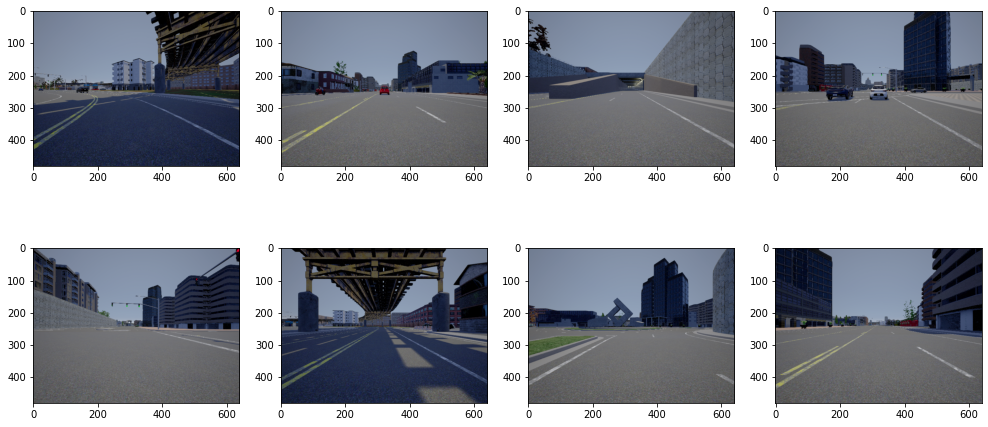

In [ ]:
fig=plt.figure(figsize=(17, 8))
columns = 4
rows = 2
for i in range(1, rows*columns + 1):
    img = debug_imgs[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# Setting up Data Generators

In [ ]:
from skimage.transform import resize
from tensorflow.keras.utils import Sequence

def DepthNorm(x, maxDepth):
    return maxDepth / x

class DataGenerator2D(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, img_paths, base_path, to_fit=True, batch_size=32, shuffle=True, debug_dir='', debug_imgs=[], augmentation_rate=0.5,
                 max_depth=100, min_depth=0):
    
        self.img_paths = img_paths.copy()
        self.base_path = base_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.debug_dir = debug_dir
        self.debug_imgs = debug_imgs
        self.epoch = 0
        self.augmentation_rate = augmentation_rate
        self.max_depth = max_depth            # Meter 
        self.min_depth = min_depth            # Meter 
        self.on_epoch_end()
    
    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(len(self.img_paths) // self.batch_size)

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        current_indexes = list(range(index * self.batch_size, (index + 1) * self.batch_size))
        img_paths_temp = self.img_paths[current_indexes]

        # Generate data
        X = []
        y = []

        for path in img_paths_temp:
          _X = cv2.cvtColor(cv2.imread(self.base_path + f"/images/{path}"), cv2.COLOR_BGR2RGB)
          _y = rgb_to_depth(cv2.imread(self.base_path + f"/depth/{path}"))
          _y = 1000.0*_y

          '''if (np.random.random() < self.augmentation_rate):
            _X = augment(_X)

          if (np.random.random() < 0.5) and self.augmentation_rate:
            _X, _y = flip(_X, _y)'''
          
          _y = np.clip(_y, self.min_depth, self.max_depth) 
          #_y = DepthNorm(_y, maxDepth=self.max_depth) 

          _y = resize(_y, (_X.shape[0]//2, _X.shape[1]//2), preserve_range=True, mode='reflect', anti_aliasing=True )
          _y = _y.reshape(_y.shape[0], _y.shape[1], 1)
          #_y = np.log(_y)

          X.append(_X)
          y.append(_y)

        if self.to_fit:
            return (np.array(X)/255).astype('float32'), np.array(y).astype('float32')
        else:
            return np.array(X).astype('float32')

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        if self.shuffle == True:
            indices = np.arange(len(self.img_paths))
            np.random.shuffle(indices)
            self.img_paths = self.img_paths[indices]
            self.img_paths.reset_index(drop=True, inplace=True)

        if self.debug_dir:
          preds = model.predict(np.array(self.debug_imgs))
          cmap = plt.get_cmap('plasma')

          for i, pred in enumerate(preds):
            pred = pred.reshape(pred.shape[0], pred.shape[1])
            location = os.path.join(self.debug_dir, f"{self.epoch}-{i}.jpg")
            cv2.imwrite(location, pred*255)

          self.epoch += 1

In [ ]:
train_generator = DataGenerator2D(img_paths_train['path'], './all/content/D', batch_size=4, shuffle=True, augmentation_rate=0.5) #debug_dir="/content/drive/My Drive/Self Driving/DenseDepth/Debug", debug_imgs=debug_imgs)
val_generator = DataGenerator2D(img_paths_val['path'], './all/content/D', batch_size=1, shuffle=False, augmentation_rate=0)

In [ ]:
# Test the generator

X, y = train_generator.__getitem__(1)
print(X.shape, y.shape)

(4, 480, 640, 3) (4, 240, 320, 1)


In [ ]:
print(X.min(), X.max())
print(y.min(), y.max())

0.0 0.94509804
0.9987061 100.0


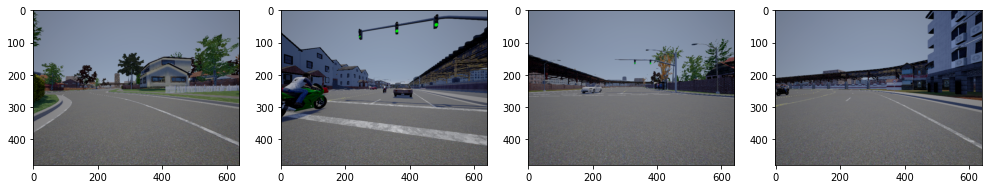

In [ ]:
fig=plt.figure(figsize=(17, 8))
columns = 4
rows = 1
for i in range(1, columns*rows + 1):
    img = X[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

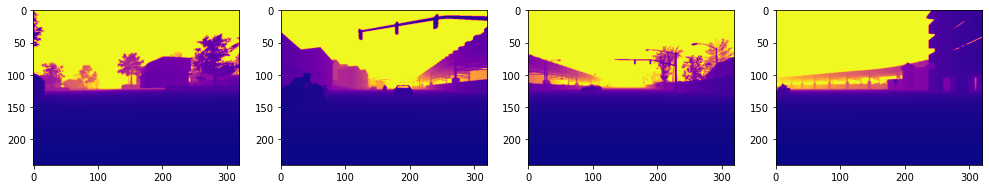

In [ ]:
fig=plt.figure(figsize=(17, 8))
columns = 4
rows = 1
for i in range(1, columns*rows + 1):
    img = y[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.reshape(img.shape[0], img.shape[1]), cmap='plasma')
plt.show()

In [ ]:
NUM_EPOCHS = 20

history = model.fit_generator(train_generator, epochs=NUM_EPOCHS, 
                                      shuffle=True, callbacks=callbacks_list,
                                       validation_data= val_generator)

Epoch 1/20
   2/6251 [..............................] - ETA: 71:01:59 - loss: 8.2071 - mae: 57.9177 

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (3.680539). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


6251/6251 [==============================] - 7773s 1s/step - loss: 1.0376 - mae: 1.6585 - val_loss: 0.5687 - val_mae: 0.7598

Epoch 00001: saving model to ./drive/My Drive/Self Driving/DenseDepth/DenseDepth2-saved-model-001-0.56871.hdf5
Epoch 2/20
6251/6251 [==============================] - 7695s 1s/step - loss: 0.7483 - mae: 0.9043 - val_loss: 0.5708 - val_mae: 1.2876

Epoch 00002: saving model to ./drive/My Drive/Self Driving/DenseDepth/DenseDepth2-saved-model-002-0.57081.hdf5
Epoch 3/20
1443/6251 [=====>........................] - ETA: 1:35:25 - loss: 0.7013 - mae: 0.8327

# Reload Training

In [ ]:
from keras.models import load_model

custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': depth_loss_function}
model = load_model('./drive/My Drive/Self Driving/DenseDepth/DenseDepth2-saved-model-002-0.57081.hdf5', custom_objects=custom_objects)

model.compile(loss=depth_loss_function, optimizer=optimizer, metrics=['mae'])

In [ ]:
NUM_EPOCHS = 20

history = model.fit_generator(train_generator, epochs=NUM_EPOCHS, 
                                      shuffle=True, callbacks=callbacks_list,
                                       validation_data= val_generator)

Epoch 1/20
   2/4688 [..............................] - ETA: 59:13:42 - loss: 0.6315 - mae: 2.3183 

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (4.311262). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


4688/4688 [==============================] - 13660s 3s/step - loss: 0.6910 - mae: 0.8406 - val_loss: 0.4971 - val_mae: 0.8785

Epoch 00001: saving model to ./drive/My Drive/Self Driving/DenseDepth/DenseDepth2-saved-model-001-0.49711.hdf5
Epoch 2/20
4688/4688 [==============================] - 13565s 3s/step - loss: 0.6494 - mae: 0.7681 - val_loss: 0.4270 - val_mae: 0.5913

Epoch 00002: saving model to ./drive/My Drive/Self Driving/DenseDepth/DenseDepth2-saved-model-002-0.42701.hdf5
Epoch 3/20
1537/4688 [========>.....................] - ETA: 2:26:56 - loss: 0.6267 - mae: 0.7421

# Test Model

In [ ]:
from keras.models import load_model

custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D}
model = load_model('./drive/My Drive/Self Driving/DenseDepth/DenseDepth-saved-model-001-0.05006.hdf5', custom_objects=custom_objects, compile=False)

In [ ]:
def predict(input):

  pred1 = model.predict(np.array([input]))[0]
  pred2 = np.flip(model.predict(np.array([np.flip(input, 1)]))[0], 1)

  final = (pred1 + pred2) / 2.0

  return final

In [ ]:
!mkdir ./all
!cp "./drive/My Drive/data/test-data.zip" "./all/rgb.zip"

In [ ]:
!unzip "./all/rgb.zip" -d "./all"

Archive:  ./all/rgb.zip
   creating: ./all/output/
  inflating: ./all/output/011368.jpg  
  inflating: ./all/output/011369.jpg  
  inflating: ./all/output/011370.jpg  
  inflating: ./all/output/011371.jpg  
  inflating: ./all/output/011372.jpg  
  inflating: ./all/output/011373.jpg  
  inflating: ./all/output/011377.jpg  
  inflating: ./all/output/011378.jpg  
  inflating: ./all/output/011379.jpg  
  inflating: ./all/output/011380.jpg  
  inflating: ./all/output/011381.jpg  
  inflating: ./all/output/011385.jpg  
  inflating: ./all/output/011387.jpg  
  inflating: ./all/output/011388.jpg  
  inflating: ./all/output/011389.jpg  
  inflating: ./all/output/011390.jpg  
  inflating: ./all/output/011391.jpg  
  inflating: ./all/output/011392.jpg  
  inflating: ./all/output/011393.jpg  
  inflating: ./all/output/011394.jpg  
  inflating: ./all/output/011395.jpg  
  inflating: ./all/output/011396.jpg  
  inflating: ./all/output/011397.jpg  
  inflating: ./all/output/011398.jpg  
  inflating: 

In [ ]:
!mkdir ./output

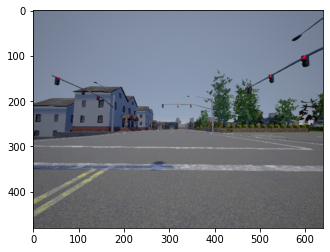

In [ ]:
input = cv2.cvtColor(cv2.imread('./all/output/012470.jpg'), cv2.COLOR_BGR2RGB) / 255.0
plt.imshow(input)

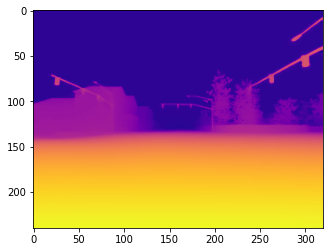

In [ ]:
pred = predict(input)
plt.imshow(np.log(pred.reshape(240, -1)), cmap='plasma')

In [ ]:
!rm -rf ./rgb
!mkdir ./rgb

from shutil import copyfile

for rgb_filename in sorted(os.listdir('./all/output'))[:200]:
  initial_location = f'all/output/{rgb_filename}'
  final_location   = f'rgb/{rgb_filename}'

  copyfile(initial_location, final_location)

In [ ]:
!zip -r ./output_rgb.zip rgb
!cp "./output_rgb.zip" "./drive/My Drive/data/output_rgb.zip"

  adding: rgb/ (stored 0%)
  adding: rgb/011540.jpg (deflated 0%)
  adding: rgb/011612.jpg (deflated 0%)
  adding: rgb/011431.jpg (deflated 0%)
  adding: rgb/011415.jpg (deflated 0%)
  adding: rgb/011566.jpg (deflated 0%)
  adding: rgb/011507.jpg (deflated 0%)
  adding: rgb/011404.jpg (deflated 0%)
  adding: rgb/011656.jpg (deflated 0%)
  adding: rgb/011601.jpg (deflated 0%)
  adding: rgb/011678.jpg (deflated 0%)
  adding: rgb/011482.jpg (deflated 0%)
  adding: rgb/011439.jpg (deflated 0%)
  adding: rgb/011371.jpg (deflated 0%)
  adding: rgb/011388.jpg (deflated 0%)
  adding: rgb/011666.jpg (deflated 0%)
  adding: rgb/011434.jpg (deflated 0%)
  adding: rgb/011466.jpg (deflated 0%)
  adding: rgb/011611.jpg (deflated 0%)
  adding: rgb/011458.jpg (deflated 0%)
  adding: rgb/011462.jpg (deflated 0%)
  adding: rgb/011521.jpg (deflated 0%)
  adding: rgb/011714.jpg (deflated 0%)
  adding: rgb/011576.jpg (deflated 0%)
  adding: rgb/011717.jpg (deflated 0%)
  adding: rgb/011495.jpg (deflated 0%

In [ ]:
import os
from skimage.transform import resize

for rgb_filename in sorted(os.listdir('./all/output'))[:200]:

  input  = cv2.cvtColor(cv2.imread(f'all/output/{rgb_filename}'), cv2.COLOR_BGR2RGB) / 255.0
  output = predict(input)  
  output = output.reshape(output.shape[0], output.shape[1])
  output = resize(output, (output.shape[0]*2, output.shape[1]*2), preserve_range=True, mode='reflect', anti_aliasing=True) 
  output = np.clip(DepthNorm(output, maxDepth=100.0), 1, 100.0)

  output.reshape(output.shape[0], output.shape[1], 1)
  np.save(f'./output/{rgb_filename}', output)

In [ ]:
!zip -r ./output.zip output

  adding: output/ (stored 0%)
  adding: output/011576.jpg.npy (deflated 33%)
  adding: output/011558.jpg.npy (deflated 34%)
  adding: output/011646.jpg.npy (deflated 31%)
  adding: output/011540.jpg.npy (deflated 31%)
  adding: output/011527.jpg.npy (deflated 34%)
  adding: output/011581.jpg.npy (deflated 33%)
  adding: output/011415.jpg.npy (deflated 36%)
  adding: output/011465.jpg.npy (deflated 35%)
  adding: output/011583.jpg.npy (deflated 32%)
  adding: output/011486.jpg.npy (deflated 32%)
  adding: output/011444.jpg.npy (deflated 35%)
  adding: output/011690.jpg.npy (deflated 36%)
  adding: output/011515.jpg.npy (deflated 34%)
  adding: output/011725.jpg.npy (deflated 35%)
  adding: output/011700.jpg.npy (deflated 36%)
  adding: output/011534.jpg.npy (deflated 33%)
  adding: output/011453.jpg.npy (deflated 33%)
  adding: output/011673.jpg.npy (deflated 31%)
  adding: output/011522.jpg.npy (deflated 34%)
  adding: output/011643.jpg.npy (deflated 33%)
  adding: output/011440.jpg.np

In [ ]:
!cp "./output.zip" "./drive/My Drive/data/output.zip"

(4, 480, 640, 3) (4, 240, 320, 1)


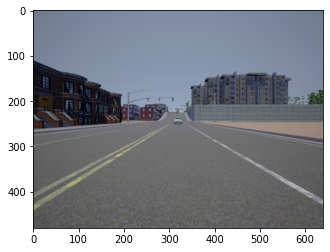

In [ ]:
# Test the Model    (Input)

X, y = train_generator.__getitem__(8)
print(X.shape, y.shape)

input = X[0]
pred = predict(input)
pred = pred.reshape(240, -1)
y = y[0].reshape(240, -1)
plt.imshow(input)

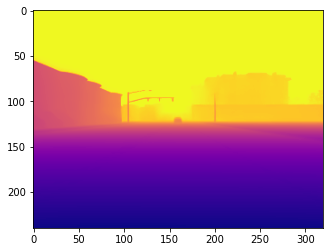

In [ ]:
# Prediction

plt.imshow(np.log(np.clip(DepthNorm(pred, maxDepth=100.0), 1, 100.0) / 100.0), cmap='plasma')

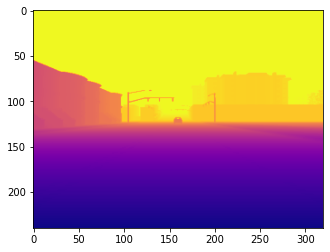

In [ ]:
# Ground Truth

plt.imshow(np.log(DepthNorm(y, 100)), cmap='plasma')

In [ ]:
from skimage.transform import resize

save = np.clip(DepthNorm(pred, maxDepth=100.0), 1, 100.0) 
save = resize(save, (save.shape[0]*2, save.shape[1]*2), preserve_range=True, mode='reflect', anti_aliasing=True )
save = save.reshape(save.shape[0], save.shape[1], 1)

np.save('depth_output10', save)
cv2.imwrite('rgb_input10.jpg', cv2.cvtColor(cv2.resize(test, (640, 480)), cv2.COLOR_RGB2BGR))

True

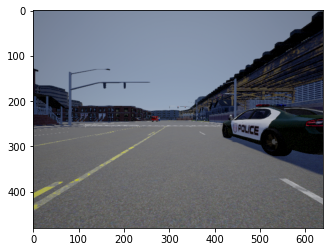

In [ ]:
test = cv2.cvtColor(cv2.imread('./011633.jpg'), cv2.COLOR_RGB2BGR) 
plt.imshow(test/255.0)

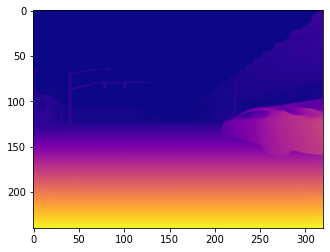

In [ ]:
pred = predict(test/255.0)
plt.imshow(pred.reshape(240, -1), cmap='plasma')